# General idea for hopfield nets

* not just any Hopfield net, but specific for hamming codes (https://proceedings.neurips.cc/paper_files/paper/2019/file/97008ea27052082be055447be9e85612-Paper.pdf)
* the fixed-points themselves may not drift! 
* (modern) hopfield network, but for weights instead of activations!
* push weights towards discrete fixed points:
    * "weight matrix" is $W=XX^T$, where $X$ are the fixed locations (must be generated in a reliable way that doesn't deteriorate)
    * "state" is the weight matrix itself (vectorized), it's updated as $\tau \frac{dx_i}{dt} = \sum_{j=1}^{N_h} W_{i,j} x_j - x_i + I_i $
    * translated to our case: $\tau \frac{dw}{dt} = (XX^T - I) w + U $, where $w$ is the weight in vectorized form
    * for a single column $w^i$ of the $W$ matrix, we have: $\tau \frac{dw^i}{dt} = \sum_{j} (XX^T - I)^{i,j} w^j + U^i = \sum_{j} ((XX^T)^{i,j} - I) W e^j + U^i = \sum_{j} (X^i (X^j)^T - I) W e^j + U^i $ 
    * here $(XX^T)^{i,j} = X^i (X^j)^T$

In [ ]:
def softmax(a: np.ndarray, axis = None, f=np.exp):
    v = f(a)
    shape = list(a.shape)
    shape[axis] = 1
    return v / np.sum(v, axis=axis).reshape(shape)

In [ ]:
X = np.array([[-0.5, -0.5], [ 0.5, -0.5], [ 0.0, 0.5]]).T
n_patterns = X.shape[1]
# X = np.array([[-0.5, -0.5], [ 0.0, 0.5]]).T
# X = np.array([[-0.5, -0.5]]).T
beta = 1.0
n_dims = 2
n_points = 10


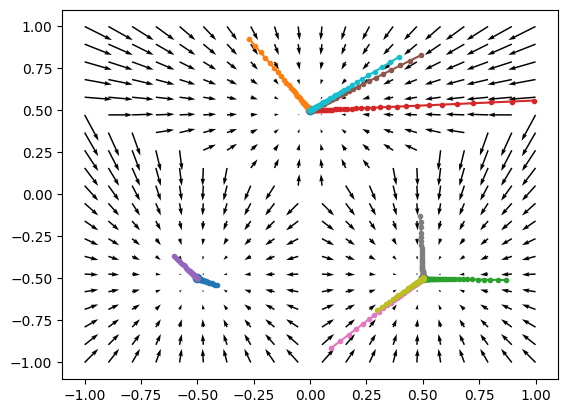

In [ ]:
num_steps = 1000

# memory
W = np.random.rand(n_dims, n_points)*2-1
beta = 200
exp_f = lambda x: np.float_power(2.0, x)

# traces
XX = np.linalg.pinv(np.dot(X,X.T))
XXX = np.dot(XX,X)
ww = np.zeros((num_steps,) + W.shape)

do_parallel = True
if do_parallel:
    for i in range(num_steps):
        ww[i] = W.copy()
        # W += 0.01*(np.dot(X, softmax(beta*np.dot(X.T, W))) - W)
        # W += 0.01*(np.dot(X, np.dot(X.T, W)) - W)
        # W = np.dot(X, np.dot(X.T, W))
        # W += 0.1*(np.dot(X, softmax(beta*np.dot(X.T, W), axis=0)) - W)
        # W = np.dot(X, softmax(beta*np.dot(X.T, W), axis=0))

        # compute the column-wise product between X vectors and the memory
        M = np.dot(X.T, W)

        W_new = np.dot(X, softmax(beta*M, axis=0, f=exp_f))

        W_old = np.dot(XXX, M)
        dW = W_new - W_old

        W += 0.1*dW
else:
    # alternative, where each sample is applied one-by-one
    denom = np.zeros((1,n_points))
    last_denom = np.sum(beta*np.dot(X.T, W), axis=0)
    for i in range(num_steps):
        ww[i] = W.copy()

        # go through each template
        for j in range(n_points):
            # generate a single sample vector
            x = X[:,[j]]

            # compute the output of the memory
            m = np.dot(x.T, W)

            # compute the nonlinearly transformed output
            s = exp_f(beta*m)

            # keep running sum of the denominator
            denom += s

            # update the memory
            dw_new = (x * s/last_denom) - np.dot(XXX, m).reshape((1,-1))

            W += 0.01*dw_new

            last_denom[:] = denom
            denom[:] = 0.0

xx, yy = np.mgrid[-1:1:20j, -1:1:20j]
Z = np.stack([xx.ravel(), yy.ravel()])
dZ = np.dot(X, softmax(beta*np.dot(X.T, Z), axis=0, f=exp_f)) - Z
plt.quiver(xx, yy, dZ[0], dZ[1])

plt.scatter(X[0], X[1])
plt.plot(ww[:,0,:], ww[:,1,:], linestyle="-", marker=".")


In [ ]:
XXX.shape, m.shape, M.shape

((2, 3), (1, 10), (3, 10))

# WHY IS THIS BETTER THAN QUANTIZING EACH ROW?!

* multiply weight $W$ with the unit vectors
* discretize & round each row separately (element-wise) to nearest allowed values 
* compute outer-product update